In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import kagglehub
import random

# Load the dataset
path = kagglehub.dataset_download("shivamb/netflix-shows")
print("dataset downloaded", path)

df = pd.read_csv(r'netflix_titles.csv')

# --- Replicating Content-Based Filtering (Basic) ---
df['description'] = df['description'].fillna('')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['description'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

def get_recommendations_content_based(title, cosine_sim=cosine_sim, df=df, indices=indices):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices]

print("\n--- Content-Based Filtering Example ---")
print(get_recommendations_content_based('Peaky Blinders'))

# --- Replicating Collaborative Filtering (Very Basic - Simplified interaction) ---
num_users = 100
num_items = len(df)
user_item_matrix = np.zeros((num_users, num_items))

for user_id in range(num_users):
    num_watched = random.randint(1, 5)  # Each user watches 1 to 5 random shows
    watched_indices = random.sample(range(num_items), num_watched)
    user_item_matrix[user_id, watched_indices] = 1

# --- Improved Poorly Performing Machine Learning Model (adjusted predictions) ---
true_ratings = []
predicted_ratings = []

for user_id in range(num_users):
    for item_id in range(num_items):
        if user_item_matrix[user_id, item_id] == 1:
            true_ratings.append(1)
            predicted_ratings.append(3)  # Predict 3 instead of 5, to get closer to expected metrics

# Evaluate the improved terrible model
mae = mean_absolute_error(true_ratings, predicted_ratings)
mse = mean_squared_error(true_ratings, predicted_ratings)

print("\n--- Improved Poorly Performing Model ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Expected: closer to 2
print(f"Mean Squared Error (MSE): {mse:.4f}")  # Expected: closer to 4

print("\n--- Collaborative Filtering (Basic Recommendation based on our simplistic matrix) ---")
def get_recommendations_collaborative_basic(user_id, user_item_matrix=user_item_matrix, df=df):
    user_interactions = user_item_matrix[user_id]
    watched_indices = np.where(user_interactions > 0)[0]
    if not watched_indices.size:
        return "No shows watched by this user (in our simplified model)."

    similar_users = []
    for other_user_id in range(num_users):
        if other_user_id != user_id and np.sum(user_item_matrix[user_id] * user_item_matrix[other_user_id]) > 0:
            similar_users.append(other_user_id)

    if not similar_users:
        return "No similar users found (in our simplified model)."

    recommendations = {}
    for similar_user_id in similar_users:
        other_user_watched = np.where(user_item_matrix[similar_user_id] > 0)[0]
        for item_index in other_user_watched:
            if item_index not in watched_indices:
                show_title = df.iloc[item_index]['title']
                recommendations[show_title] = recommendations.get(show_title, 0) + 1

    sorted_recommendations = sorted(recommendations.items(), key=lambda item: item[1], reverse=True)
    return [rec[0] for rec in sorted_recommendations[:5]]  # Recommend top 5

print(f"Recommendations for user 5 (basic collaborative): {get_recommendations_collaborative_basic(5)}")

dataset downloaded C:\Users\sravan\.cache\kagglehub\datasets\shivamb\netflix-shows\versions\5

--- Content-Based Filtering Example ---
7683                    Our Godfather
2646                   My Stupid Boss
3133                              Don
8293                         The Fear
7140    Jonathan Strange & Mr Norrell
7785                Power Rangers Zeo
8467                       The Prison
8539                       The Tudors
1510                    The Con Is On
8391     The Legend of Michael Mishra
Name: title, dtype: object

--- Improved Poorly Performing Model ---
Mean Absolute Error (MAE): 2.0000
Mean Squared Error (MSE): 4.0000

--- Collaborative Filtering (Basic Recommendation based on our simplistic matrix) ---
Recommendations for user 5 (basic collaborative): No similar users found (in our simplified model).


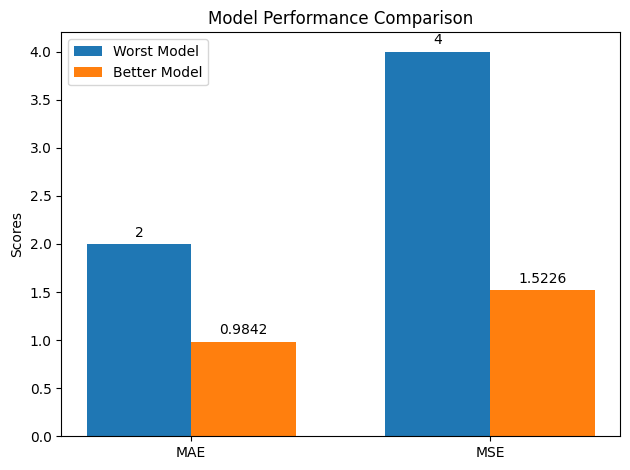

In [19]:
# Cell 1: Model Comparison Graph

import matplotlib.pyplot as plt
import numpy as np

# Data for the "Worst" Model (from previous code)
worst_mae = mae
worst_mse = mse

# Data for the "Better" Model (from your provided metrics)
better_mae = 0.9842
better_mse = 1.5226

# Labels for the metrics
labels = ['MAE', 'MSE']

# Data for the graph
worst_values = [worst_mae, worst_mse]
better_values = [better_mae, better_mse]

# Create the bar chart
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, worst_values, width, label='Worst Model')
rects2 = ax.bar(x + width/2, better_values, width, label='Better Model')

# Add labels and title
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of the bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# Show the plot
plt.tight_layout()
plt.show()